In [3]:
from datetime import datetime
import math
import numpy as np
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
# df = pd.read_csv('washing_machine.csv')
df = pd.read_csv('event detection/sample.csv')
df['ts'] = pd.to_datetime(df['ts'], unit='ms')
df.set_index('ts', inplace=True, drop=True)
df = df.resample('20ms').max()
df['apwrA'] = df['vltA']*df['curA']
df['rpwrA'] = np.sqrt(df['apwrA']**2 - df['pwrA']**2)
# df = df[['pwrA']]
# df.rename(columns={'pwrB':'pwrA'},inplace=True)
df = df.fillna(method='ffill')


df['event']=0
df.head(3000)

/home/emilyp/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,pwrA,pwrB,pwrC,cnrgA,cnrgB,cnrgC,cosA,cosB,cosC,curA,curB,curC,vltA,vltB,vltC,apwrA,rpwrA,event
ts,,,,,,,,,,,,,,,,,,
2021-04-16 21:28:00.000,105.162,113.285,220.247,4273211.0,2741240.0,2494327.0,-0.813,-0.583,-0.800,0.545,0.819,1.195,237.063,236.952,230.285,129.199335,75.056125,0
2021-04-16 21:28:00.020,105.525,113.219,219.537,4273211.0,2741240.0,2494327.0,-0.812,-0.583,-0.798,0.548,0.819,1.193,237.052,236.942,230.280,129.904496,75.760494,0
2021-04-16 21:28:00.040,105.773,113.120,218.959,4273211.0,2741240.0,2494327.0,-0.810,-0.583,-0.798,0.551,0.818,1.191,237.041,236.931,230.273,130.609591,76.622045,0
2021-04-16 21:28:00.060,105.888,113.236,218.480,4273211.0,2741240.0,2494327.0,-0.807,-0.584,-0.797,0.553,0.818,1.189,237.031,236.922,230.265,131.078143,77.260669,0
2021-04-16 21:28:00.080,105.789,113.219,218.100,4273211.0,2741240.0,2494327.0,-0.804,-0.584,-0.797,0.555,0.818,1.187,237.022,236.914,230.258,131.547210,78.187953,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-16 21:28:59.900,123.044,130.210,187.983,4273213.0,2741242.0,2494330.0,-0.835,-0.629,-0.767,0.621,0.876,1.065,236.902,236.044,230.080,147.116142,80.643247,0
2021-04-16 21:28:59.920,123.308,130.391,187.406,4273213.0,2741242.0,2494330.0,-0.837,-0.630,-0.765,0.621,0.877,1.064,236.905,236.047,230.084,147.118005,80.242411,0
2021-04-16 21:28:59.940,123.886,130.259,186.943,4273213.0,2741242.0,2494330.0,-0.840,-0.629,-0.764,0.622,0.877,1.063,236.906,236.049,230.088,147.355532,79.786664,0


In [27]:
interval = 20
repint = 60000/interval
window = 5 # window has duration 100msec

buffer = []
thres = 50 #Watts
duration = 2*(1000/interval) # 2000 msec ~ aka 2seconds
report=np.nan
event=0

In [28]:
counter = 0
for i in range(df.shape[0]):
    counter += 1
    if event==0:
        # if the buffer is not a full window, keep appending new samples. Else pop first item and append new item
        if len(buffer)<window:
#             print('buffer still not full...', buffer)
            buffer.append(df['pwrA'].iloc[i])
        else:
            buffer.pop(0)
            buffer.append(df['pwrA'].iloc[i])
            
            # if there is a reported value to compare with, check absolute difference with current window
            if not math.isnan(report): 
                if np.abs(np.mean(buffer)-report)>thres:
                    # start transmitting at high frequency
                    df['event'].iloc[i]=1
                    event=1
                    counter=0
                    #print('buffer state at the beginning of event:',buffer)
        
        # when report interval is reached, send average of window to cloud
        if counter == repint:
            report = np.mean(buffer)
#             print('Reached report interval:',report)
            counter=0
            
    # on event mode, continuous streaming
    else:
        buffer.pop(0)
        buffer.append(df['pwrA'].iloc[i])
        if counter == duration: # if 2 seconds have passed
            event = 0
            counter=0
            report = np.mean(buffer)
            buffer = []
#             print('end of event')
        
        


/home/emilyp/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


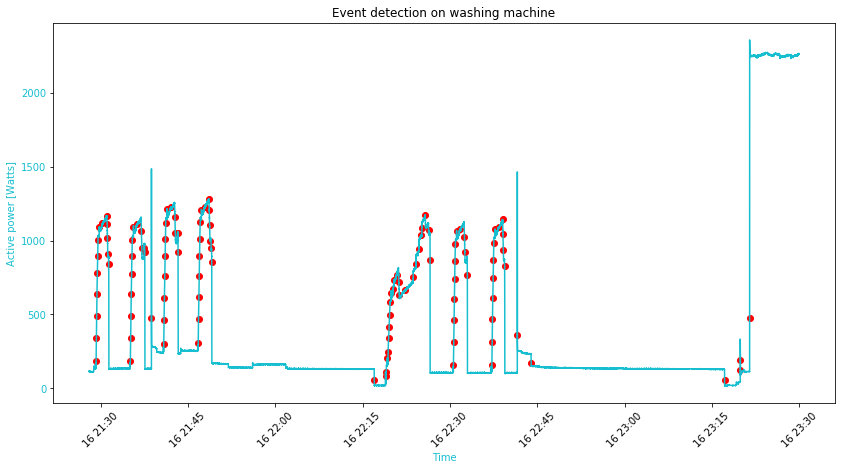

In [29]:
fig, ax1 = plt.subplots(figsize=(14, 7.0))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
color = 'tab:cyan'
ax1.plot(df.index, df['pwrA'], '-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Active power [Watts]', color=color)
ax1.set_xlabel('Time', color=color)
ax1.set_title('Event detection on washing machine')

# Add below threshold markers
cl0 = df['event']==0
cl1 = df['event']==1

# ax1.scatter(clustered.index[cl0], clustered['totalpwr'][cl0], color='red') 
ax1.scatter(df.index[cl1], df['pwrA'][cl1], color='red') 



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


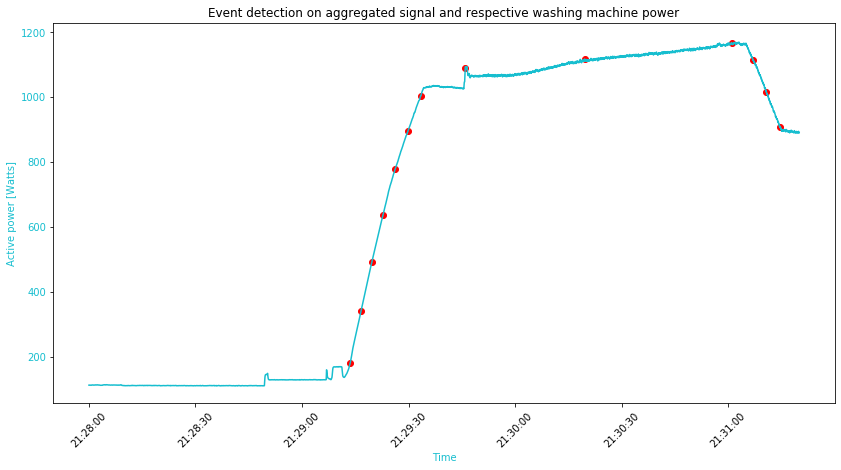

In [30]:
tmp = df.iloc[:10000]
fig, ax1 = plt.subplots(figsize=(14, 7.0))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
color = 'tab:cyan'
ax1.plot(tmp.index, tmp['pwrA'], '-', color=color)
# ax1.plot(df2.index[:10000], df2['pwrA'].iloc[:10000], '-', color='tab:orange')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Active power [Watts]', color=color)
ax1.set_xlabel('Time', color=color)
ax1.set_title('Event detection on aggregated signal and respective washing machine power')
# plt.legend(['Aggregated signal','Washing machine'])

# Add below threshold markers
cl0 = tmp['event']==0
cl1 = tmp['event']==1

# ax1.scatter(clustered.index[cl0], clustered['totalpwr'][cl0], color='red') 
ax1.scatter(tmp.index[cl1], tmp['pwrA'][cl1], color='red') 



In [12]:
df.shape


(366000, 2)

In [13]:
df.loc[df['event']==1,'event'].sum()

1076

In [14]:
df2 = pd.read_csv('washing_machine.csv')
df2['ts'] = pd.to_datetime(df2['ts'], unit='ms')
df2.set_index('ts', inplace=True, drop=True)
df2 = df2.resample('20ms').max()
df2 = df2.fillna(method='ffill')


/home/emilyp/.local/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/emilyp/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


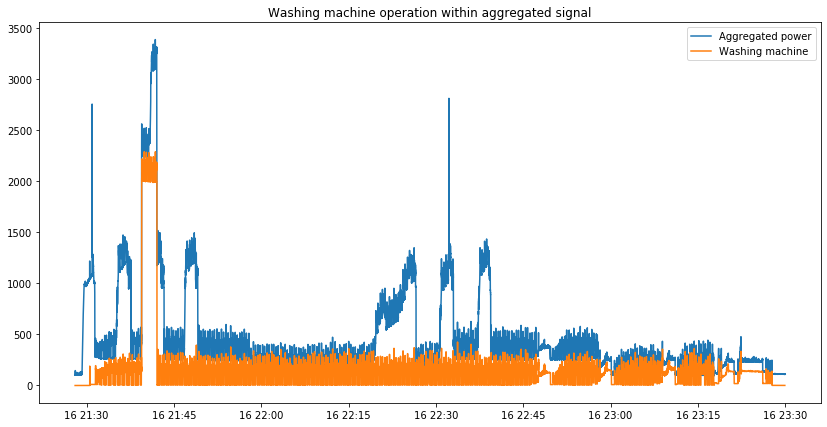

In [68]:
fig = plt.figure(figsize=(14, 7.0))
plt.plot(df.index, df['pwrA'])
plt.plot(df2.index, df2['pwrA'])
plt.title('Washing machine operation within aggregated signal')
plt.legend(['Aggregated power','Washing machine'])